# Stokes Eigenvalue Solver with NGSolve

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw

import scipy.sparse as sp
from scipy.sparse.linalg import eigs, eigsh, norm
import numpy as np

In [3]:
def bilinearform_to_scipy(a):
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    return A
def compute_eigenvalues_bilinearform(a, m, num_eigenvalues, shift=0.0):
    # sparse scipy matrices
    Afull = bilinearform_to_scipy(a)
    Mfull = bilinearform_to_scipy(m)
    
    fd = np.nonzero(a.space.FreeDofs())[0]
    # velocity_space = a.space.components[0]
    # pressure_fixed_dof = velocity_space.ndof
    # fd = np.setdiff1d(fd, [pressure_fixed_dof])
    A = Afull[fd,:][:,fd]
    M = Mfull[fd,:][:,fd]
    print("Computing eigenvalues...")
    fes = a.space
    lams_SM, ui = eigs(A = A, k = num_eigenvalues, M=M, tol=1e-12, return_eigenvectors=True, sigma=shift, which='LM', OPpart='r')
    print("Computed eigenvalues (shift-and-invert):", lams_SM)
    ui_temp = np.zeros((fes.ndof,num_eigenvalues), dtype=np.float64)
    for j in range(num_eigenvalues):
        ui_temp[fd,j] = ui[:,j].real
    return ui_temp, lams_SM               
def Stokes_bilinearforms(mesh, dirichletbnd=[], avgpressure=False):
    V = VectorH1(mesh, order=2, dirichlet = dirichletbnd)  
    Q = H1(mesh, order=1)  
    if avgpressure:
        N = NumberSpace(mesh)
        X= V*Q*N
        (u,p,lam), (v,q,mu) = X.TnT()
        epsilon=1e-12
        a = BilinearForm(X)
        a += InnerProduct(Grad(u),Grad(v))*dx + div(u)*q*dx + div(v)*p*dx +epsilon*p*q*dx + lam*q*dx + mu*p*dx
        a.Assemble()
    else:
        X = V*Q
        (u,p), (v,q) = X.TnT()
        epsilon=1e-12
        a = BilinearForm(X)
        a += InnerProduct(Grad(u),Grad(v))*dx + div(u)*q*dx + div(v)*p*dx +epsilon*p*q*dx
        a.Assemble()
    m = BilinearForm(X)
    m += u*v*dx 
    m.Assemble()       
    return a, m

In [4]:
import matplotlib.pyplot as plt

def plot_continuous_linear(Coordinates, Elements, ph, **kwargs):
    import matplotlib.tri as tri
    cmap = plt.cm.jet
    plot_kwargs = kwargs["plot_kwargs"] if "plot_kwargs" in kwargs else {}
    x = Coordinates[:, 0]
    y = Coordinates[:, 1]
    triangles = Elements

    triang = tri.Triangulation(x, y, triangles)
    if "ax" not in kwargs:
        fig = plt.figure(**{k: v for k, v in kwargs.items()
                            if k in ['figsize']})
        ax = fig.add_subplot(111)
        aspect = kwargs["aspect"] if "aspect" in kwargs else 1.0
        ax.set_aspect(aspect)
        ax.set_axis_off()
    else:
        ax = kwargs["ax"]
    im = ax.tripcolor(triang, ph, cmap=cmap,
                          **{k: v for k, v in kwargs.items()
                             if k in ['shading',
                                      'edgecolors',
                                      'vmin',
                                      'vmax']},  # for backwards compatibility
                          **plot_kwargs)
    if "colorbar" in kwargs and kwargs["colorbar"] is not False:
        if isinstance(kwargs["colorbar"], str):
            plt.colorbar(im, ax=ax, label=kwargs["colorbar"])
        elif isinstance(kwargs["colorbar"], dict):
            plt.colorbar(im, ax=ax, **kwargs["colorbar"])
        else:
            plt.colorbar(im, ax=ax)

    ax.show = lambda: plt.show()
    return ax


def plot_all_eigenfunctions(mesh, gf, num_eigenvalues=20, filename=None):
    Coordinates = np.array([v.point for v in mesh.vertices])
    Elements = np.array([[v.nr for v in el.vertices] for el in mesh.Elements(VOL)])
    num_rows = num_eigenvalues//4
    fig_p, axes_p = plt.subplots(num_rows, 4, figsize=(20,int(5*num_rows)))
    axes_p = axes_p.flatten()
    fig_v, axes_v = plt.subplots(num_rows, 4, figsize=(20,int(5*num_rows)))
    axes_v = axes_v.flatten()
    for i in range(num_eigenvalues):
        gfi = GridFunction(gf.space)
        gfi.vec.data = gf.vecs[i]
        ui = gfi.components[0]
        pi = gfi.components[1]
        ui_np = ui.vec.FV().NumPy()
        pi_np = pi.vec.FV().NumPy()
        plot_continuous_linear(Coordinates, Elements, pi_np, ax= axes_p[i], shading='gouraud', cmap='viridis')
        u1 = ui_np[:ui_np.shape[0]//2]  
        u2 = ui_np[ui_np.shape[0]//2:]
        velocity_norm = np.sqrt(u1**2 + u2**2)
        plot_continuous_linear(Coordinates, Elements, velocity_norm[:Coordinates.shape[0]], ax= axes_v[i], shading='gouraud', cmap='viridis')
        axes_p[i].set_title(f'Pressure Eigenmode {i+1}')
        axes_p[i].set_aspect('equal')
        axes_v[i].set_title(f'Velocity Eigenmode {i+1}')
        axes_v[i].set_aspect('equal')
    if filename is not None:
        fig_p.savefig(filename + '_pressure_eigenmodes.png')
        fig_v.savefig(filename + '_velocity_eigenmodes.png')


In [49]:
# No funciona...
def refine_mesh_uniform(Coordinates, Elements):
    # 1. Get all unique edges
    # We use the sorted version to ensure consistency
    all_edges = np.sort(np.concatenate([
        Elements[:, [0, 1]],
        Elements[:, [1, 2]],
        Elements[:, [2, 0]]
    ]), axis=1)
    
    unique_edges, inverse_indices = np.unique(all_edges, axis=0, return_inverse=True)
    
    # 2. Generate Midpoints
    midpoints = (Coordinates[unique_edges[:, 0]] + Coordinates[unique_edges[:, 1]]) / 2
    
    # New Coordinates = Old Coordinates + Midpoints
    new_Coordinates = np.vstack([Coordinates, midpoints])
    
    # Shift index for midpoints: the first midpoint is at index len(Coordinates)
    midpoint_offset = len(Coordinates)
    
    # 3. Reshape inverse_indices to match the shape of the 'all_edges' we created
    # This tells us, for each triangle, which unique edge index its 3 edges belong to
    edge_indices = inverse_indices.reshape((-1, 3)) + midpoint_offset
    
    new_Elements = []
    for i, el in enumerate(Elements):
        n1, n2, n3 = el
        # m12 is the midpoint of edge (n1, n2), etc.
        # Based on our 'all_edges' concatenation order: 0: (n1,n2), 1: (n2,n3), 2: (n3,n1)
        m12 = edge_indices[i, 0]
        m23 = edge_indices[i, 1]
        m31 = edge_indices[i, 2]
        
        # Add the 4 new triangles
        new_Elements.extend([
            [n1, m12, m31],
            [n2, m23, m12],
            [n3, m31, m23],
            [m12, m23, m31]
        ])
        
    return new_Coordinates, np.array(new_Elements)

def plot_continuous_quadratic(Coordinates, Elements, uh, **kwargs):
    # refine mesh
    refined_Coordinates, refined_Elements = refine_mesh_uniform(Coordinates, Elements)
    import matplotlib.tri as tri
    cmap = plt.cm.jet
    plot_kwargs = kwargs["plot_kwargs"] if "plot_kwargs" in kwargs else {}
    x = refined_Coordinates[:, 0]
    y = refined_Coordinates[:, 1]
    triangles = refined_Elements

    triang = tri.Triangulation(x, y, triangles)
    if "ax" not in kwargs:
        fig = plt.figure(**{k: v for k, v in kwargs.items()
                            if k in ['figsize']})
        ax = fig.add_subplot(111)
        aspect = kwargs["aspect"] if "aspect" in kwargs else 1.0
        ax.set_aspect(aspect)
        ax.set_axis_off()
    else:
        ax = kwargs["ax"]
    im = ax.tripcolor(triang, uh, cmap=cmap,
                          **{k: v for k, v in kwargs.items()
                             if k in ['shading',
                                      'edgecolors',
                                      'vmin',
                                      'vmax']},  # for backwards compatibility
                          **plot_kwargs)
    if "colorbar" in kwargs and kwargs["colorbar"] is not False:
        if isinstance(kwargs["colorbar"], str):
            plt.colorbar(im, ax=ax, label=kwargs["colorbar"])
        elif isinstance(kwargs["colorbar"], dict):
            plt.colorbar(im, ax=ax, **kwargs["colorbar"])
        else:
            plt.colorbar(im, ax=ax)

    ax.show = lambda: plt.show()
    return ax

## 1. Unit Square

In [4]:
unit_mesh = Mesh(unit_square.GenerateMesh(maxh=0.025))
a,m = Stokes_bilinearforms(unit_mesh, dirichletbnd="left|bottom|right|top", avgpressure=True)
num_eigenvalues = 40
ui_unitsq_scipy, lams_SM = compute_eigenvalues_bilinearform(a, m, num_eigenvalues=num_eigenvalues, shift=10.0)
gf_stokes = GridFunction(a.space, multidim=num_eigenvalues)
for j in range(0,num_eigenvalues):
    gf_stokes.vecs[j].FV().NumPy()[:] = ui_unitsq_scipy[:,j].real

Computing eigenvalues...
Computed eigenvalues (shift-and-invert): [ 52.34475831+0.j  92.12469841+0.j  92.12468361+0.j 128.21044426+0.j
 154.12669543+0.j 167.03071426+0.j 189.57430993+0.j 189.57443388+0.j
 269.12754615+0.j 246.33283119+0.j 246.32698785+0.j 246.32705493+0.j
 279.08658321+0.j 326.65535883+0.j 326.65583589+0.j 349.3293982 +0.j
 362.76593967+0.j 380.3246707 +0.j 380.32508615+0.j 403.88984652+0.j
 425.4445242 +0.j 434.81463115+0.j 481.7219525 +0.j 481.72178243+0.j
 501.05886914+0.j 511.93990229+0.j 503.99273304+0.j 503.99208921+0.j
 554.61310102+0.j 554.61374108+0.j 600.92164904+0.j 621.77515199+0.j
 624.73103376+0.j 630.52842121+0.j 638.76782354+0.j 653.45715353+0.j
 653.45659121+0.j 694.84755169+0.j 705.04179871+0.j 720.6501326 +0.j]


In [46]:
plot_all_eigenfunctions(unit_mesh, gf_stokes, filename="unit_square", num_eigenvalues=40)

## 2. U mesh

In [5]:
Umesh = Mesh("U_mesh.vol")
a,m = Stokes_bilinearforms(Umesh, dirichletbnd="wall",avgpressure=True)
num_eigenvalues = 20
ui_scipy, lams_SM = compute_eigenvalues_bilinearform(a, m, num_eigenvalues,shift=100)
gf_stokes = GridFunction(a.space, multidim=num_eigenvalues)
for j in range(num_eigenvalues):
    gf_stokes.vecs[j].FV().NumPy()[:] = ui_scipy[:,j].real

Computing eigenvalues...
Computed eigenvalues (shift-and-invert): [ 44.86419952+0.j  43.39105491+0.j 145.09427415+0.j 145.09238059+0.j
 154.45867203+0.j 156.49176544+0.j 162.64820635+0.j 163.40219175+0.j
 163.24863067+0.j 165.19052195+0.j 167.18106206+0.j 167.72725564+0.j
 170.57529914+0.j 170.81209026+0.j 171.34986992+0.j 174.72465677+0.j
 177.46660638+0.j 184.95791736+0.j 193.61225701+0.j 203.79233875+0.j]


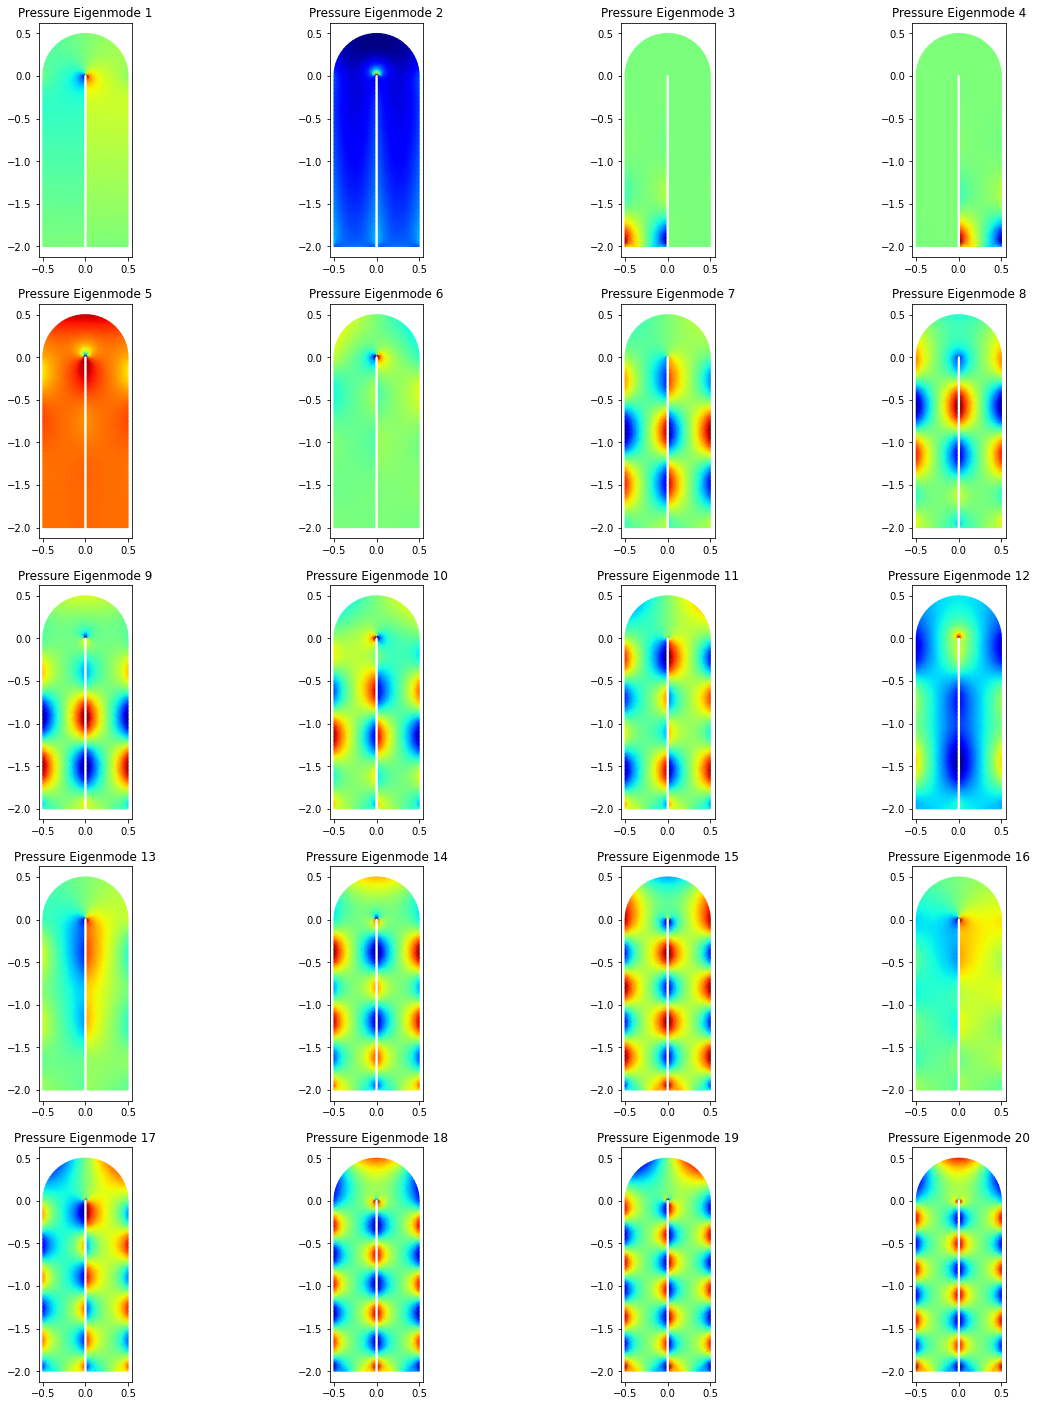

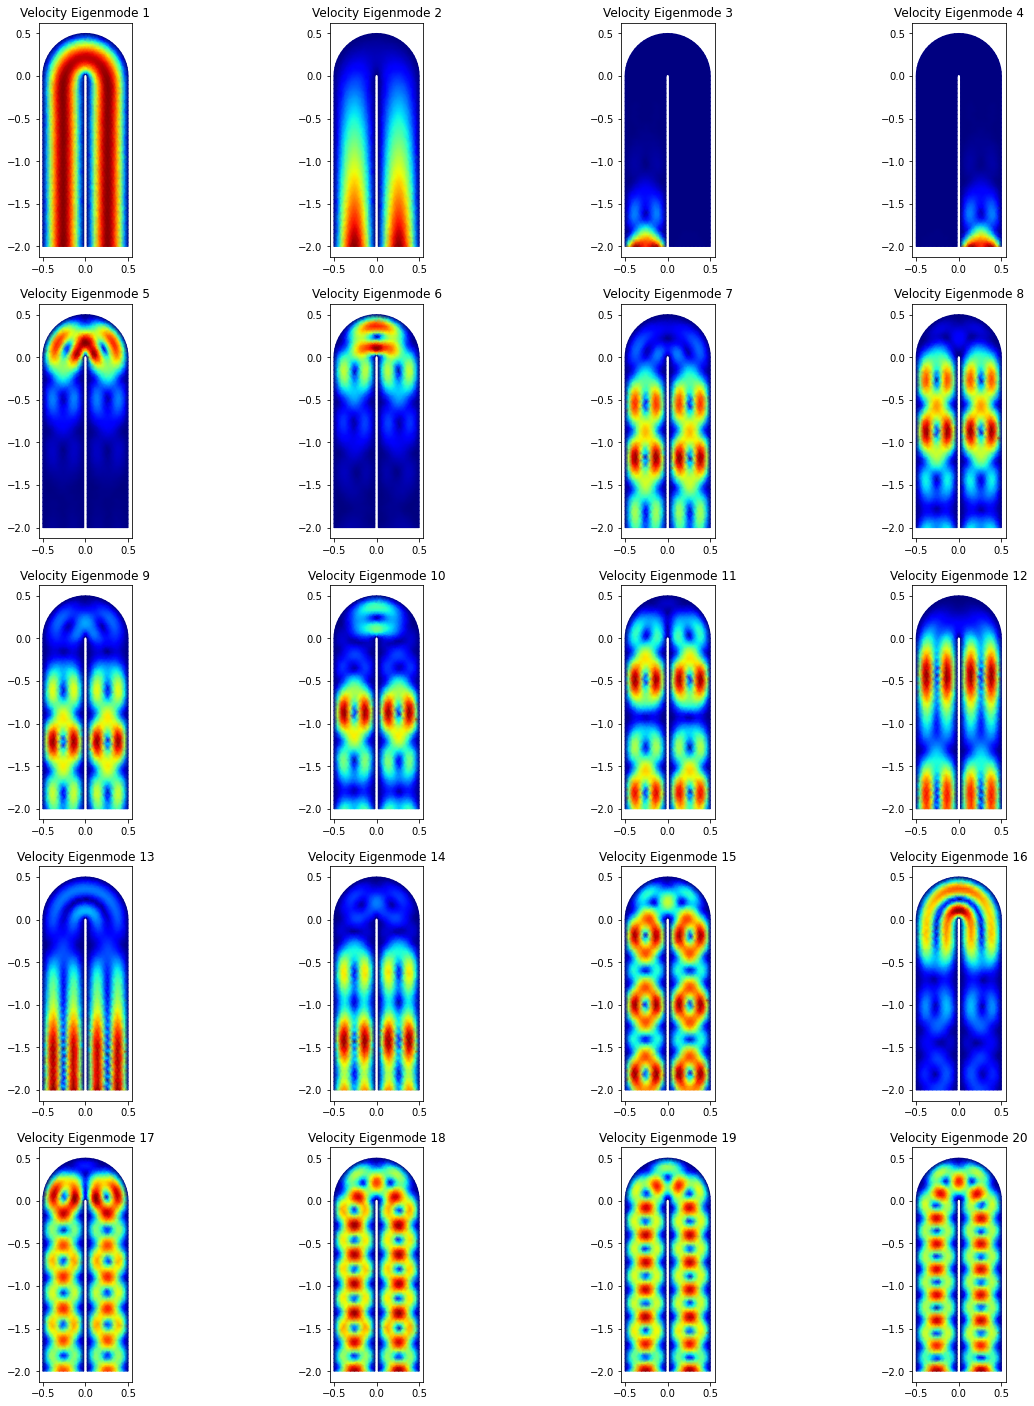

In [6]:
# Plot NGSolve
# Draw(gf_stokes.components[0], Umesh, 'eigenmodes_velocity')
# Draw(gf_stokes.components[1], Umesh, 'eigenmodes_pressure')
plot_all_eigenfunctions(Umesh, gf_stokes, filename="Umesh", num_eigenvalues=num_eigenvalues)

## 3. U mesh refinada

In [7]:
Umesh_refinada = Mesh("U_mesh_refinada.vol")

In [8]:
a,m = Stokes_bilinearforms(Umesh_refinada, dirichletbnd="wall", avgpressure=True)
num_eigenvalues = 40
ui_diff_scipy, lams_SM = compute_eigenvalues_bilinearform(a, m, num_eigenvalues=num_eigenvalues,shift=1000)
gf_stokes = GridFunction(a.space, multidim=num_eigenvalues)
for j in range(0,num_eigenvalues):
    gf_stokes.vecs[j].FV().NumPy()[:] = ui_diff_scipy[:,j].real

Computing eigenvalues...


: 

In [ ]:
plot_all_eigenfunctions(Umesh_refinada, gf_stokes, filename="Umesh_refinada", num_eigenvalues=num_eigenvalues)

In [ ]:
Draw(gf_stokes.components[0], Umesh_refinada, 'eigenmodes_velocity')

# 3. Arteria 2d

In [4]:
arteria2d_mesh = Mesh("arteria_mesh.vol")
# Draw(arteria2d_mesh)

In [7]:
a,m = Stokes_bilinearforms(arteria2d_mesh, dirichletbnd="wall", avgpressure=True)
ui_diff_scipy, lams_SM = compute_eigenvalues_bilinearform(a, m, num_eigenvalues=40,shift=1000)


Computing eigenvalues...
Computed eigenvalues (shift-and-invert): [1004.47515156+0.j 1850.9154348 +0.j 1898.66027079+0.j 2083.31942539+0.j
 2352.82990296+0.j 2428.44188774+0.j 2506.30105811+0.j 2518.98832836+0.j
 2622.22429148+0.j 2691.90710964+0.j 2760.62320237+0.j 2815.85707246+0.j
 2888.84163092+0.j 2982.10199863+0.j 3004.26008826+0.j 3075.01278153+0.j
 3130.01123615+0.j 3185.69040505+0.j 3210.49150569+0.j 3269.95244947+0.j
 3343.99986087+0.j 3421.132533  +0.j 3437.50653429+0.j 3444.66395339+0.j
 3494.95287702+0.j 3563.6508026 +0.j 3627.05056869+0.j 3672.20741559+0.j
 3704.34779132+0.j 3745.36820285+0.j 3811.17461155+0.j 3882.62539438+0.j
 3916.83428962+0.j 3977.63860081+0.j 4092.19824826+0.j 4186.13725657+0.j
 4257.57497336+0.j 4273.49822019+0.j 4304.54567919+0.j 4345.09789509+0.j]


In [8]:
num_eigenvalues = 40
gf_stokes = GridFunction(a.space, multidim=num_eigenvalues)
for j in range(0,num_eigenvalues):
    gf_stokes.vecs[j].FV().NumPy()[:] = ui_diff_scipy[:,j].real

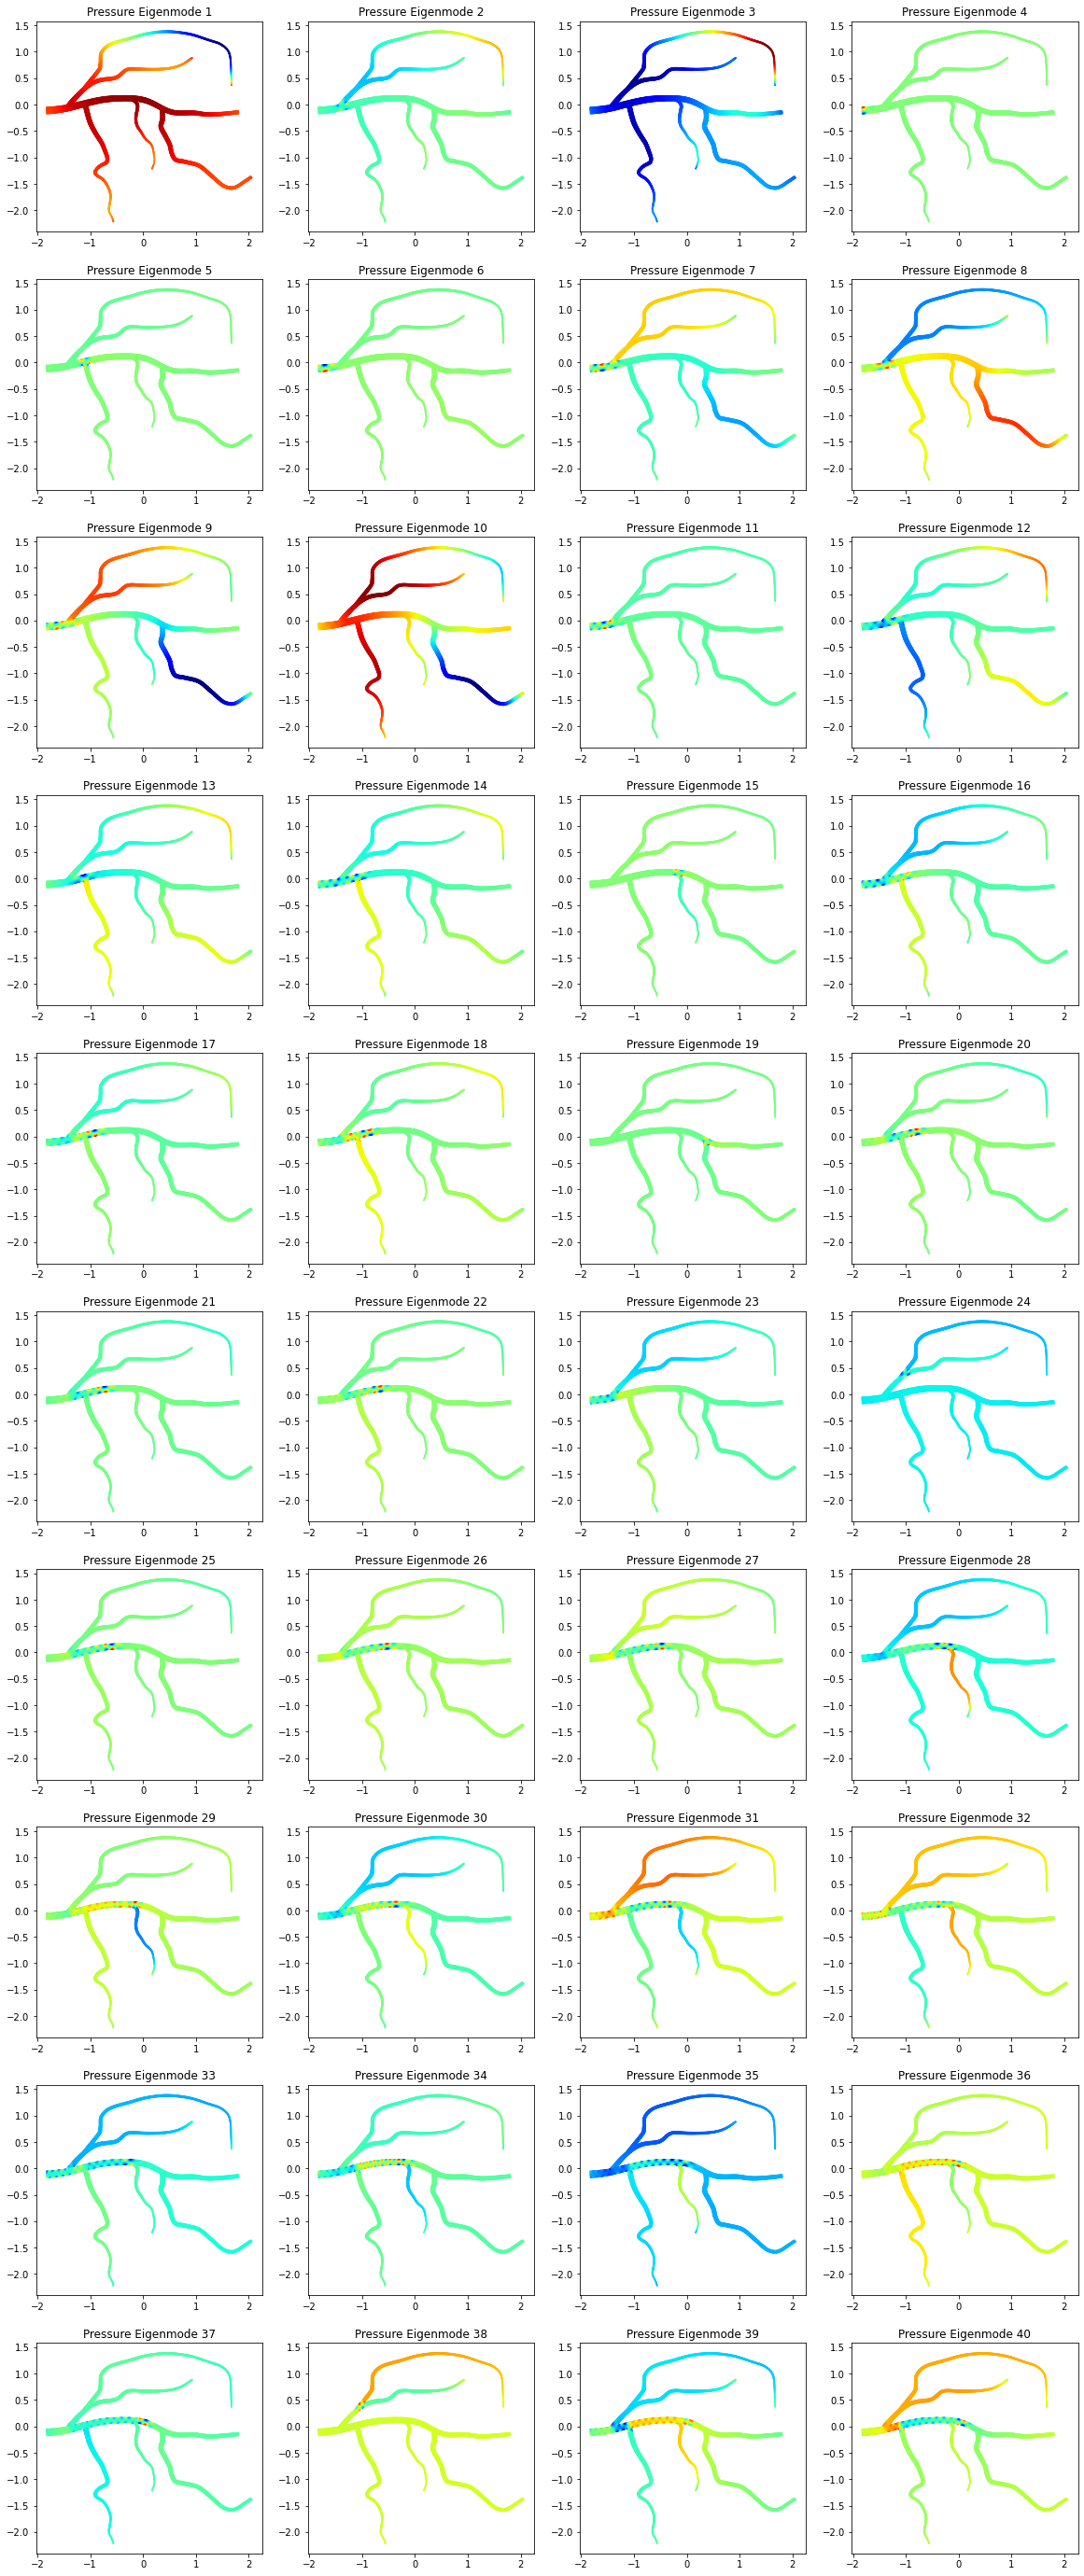

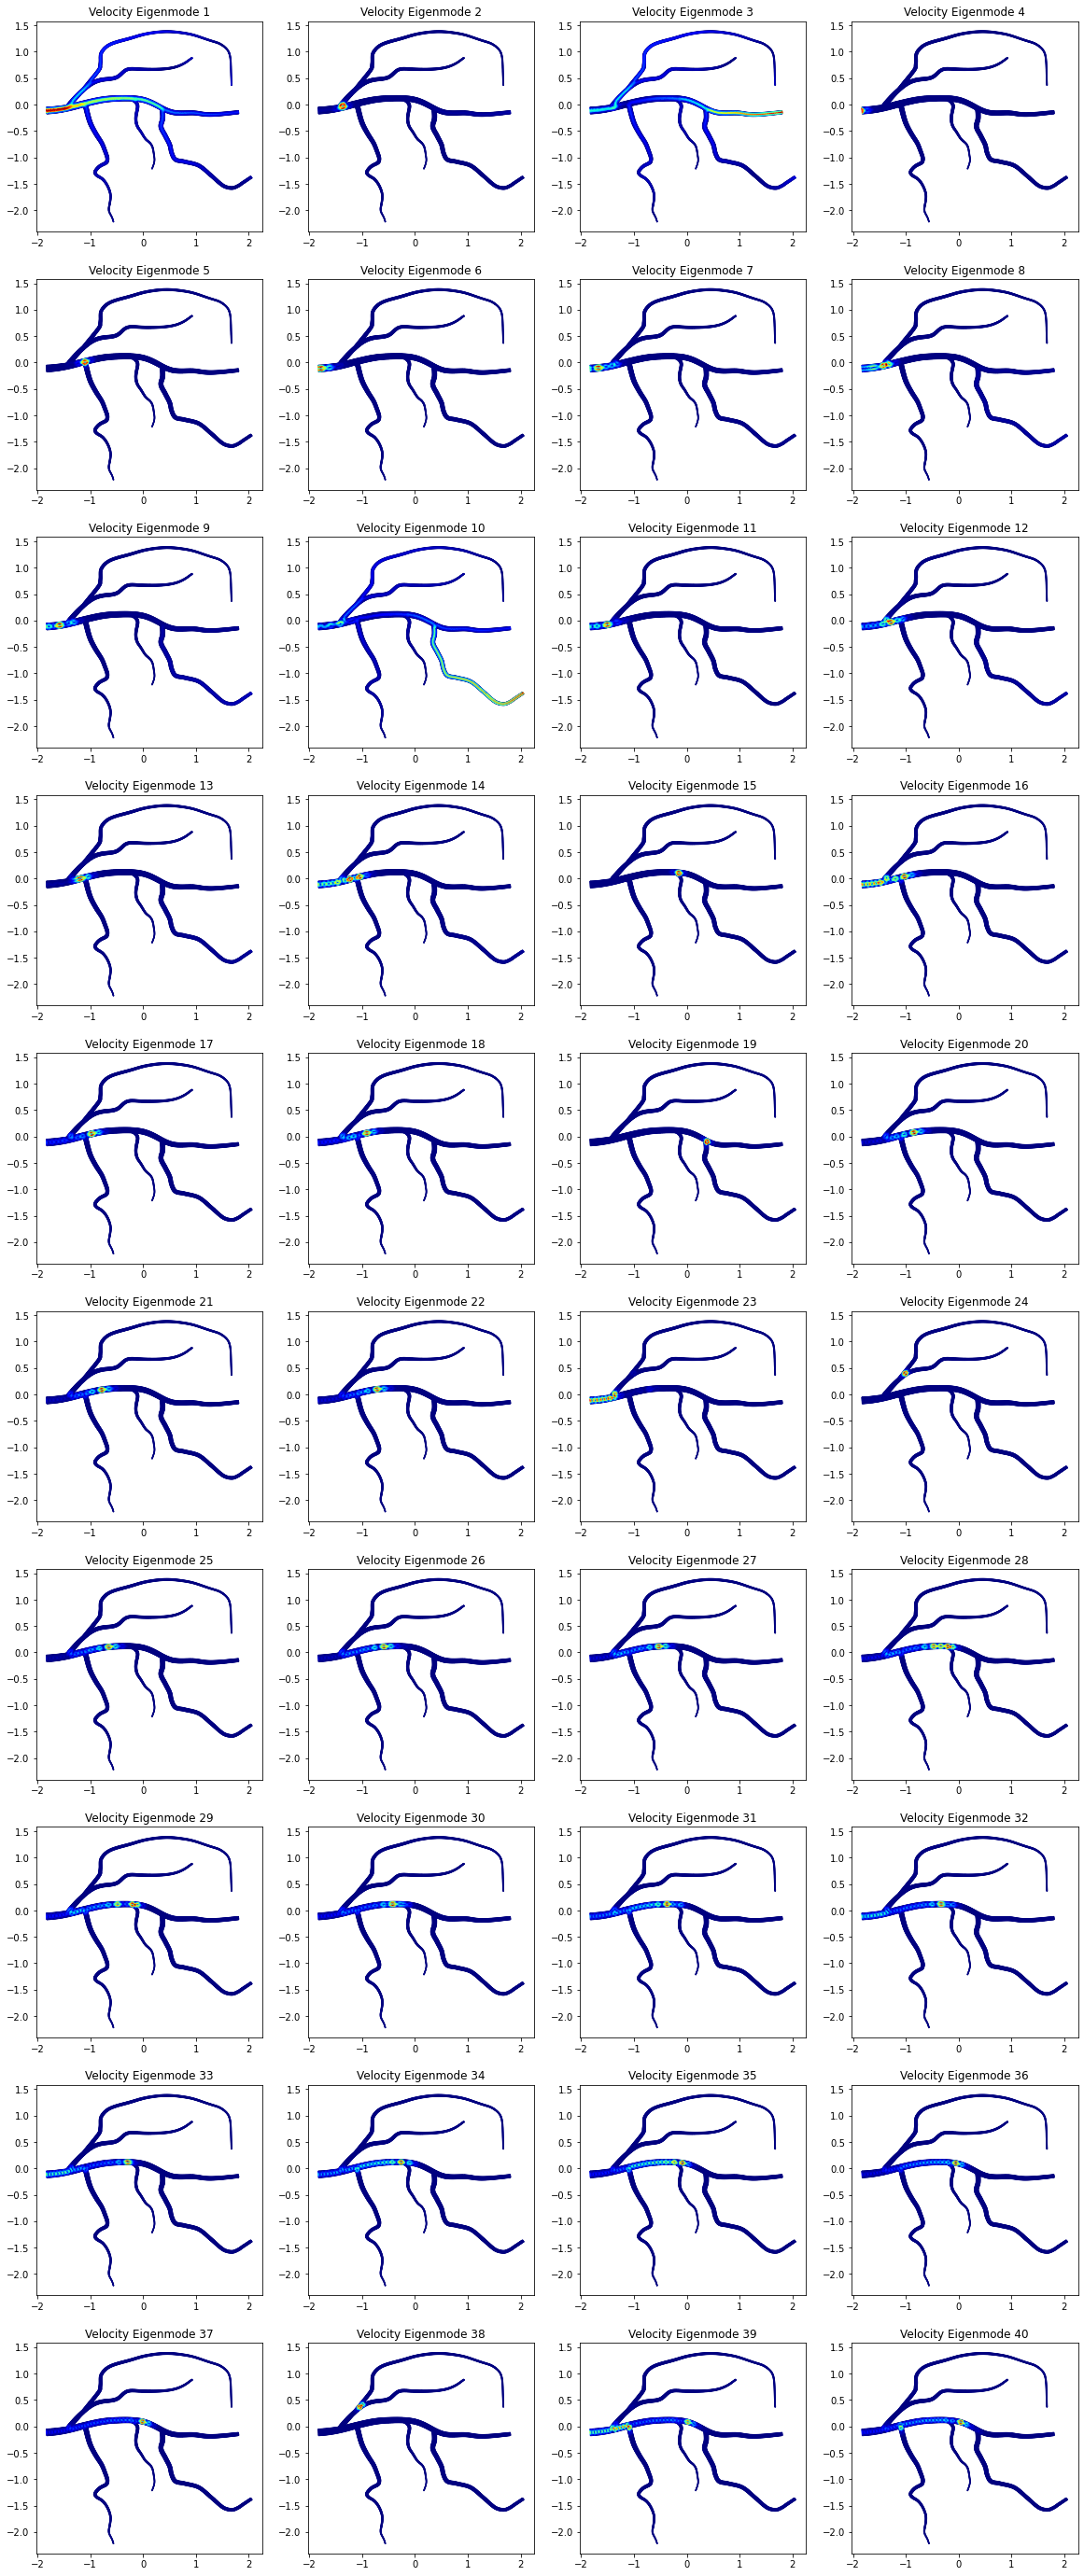

In [9]:
# Draw(gf_stokes.components[1], arteria2d_mesh, 'eigenmodes_velocity')
plot_all_eigenfunctions(arteria2d_mesh, gf_stokes, filename="arteria2d_mesh", num_eigenvalues=num_eigenvalues)